In [455]:
#Computation & Visualisation packages
library(ggplot2)
library(dplyr)
library(plyr)
library(knitr)
library(corrplot)
library(caret)
library(gridExtra)
library(scales)
library(Rmisc)
library(ggrepel)
library(psych)
library(xgboost)
library(randomForest)
library(caTools)
library(Ckmeans.1d.dp)

# Suppress warnings
options(warn=-1)

In [456]:
#Loading the housing dataset
data <- read.csv('data/housing_prices.csv', stringsAsFactor=F)

In [457]:
str(data)

'data.frame':	1460 obs. of  81 variables:
 $ Id           : int  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass   : int  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning     : chr  "RL" "RL" "RL" "RL" ...
 $ LotFrontage  : int  65 80 68 60 84 85 75 NA 51 50 ...
 $ LotArea      : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ Street       : chr  "Pave" "Pave" "Pave" "Pave" ...
 $ Alley        : chr  NA NA NA NA ...
 $ LotShape     : chr  "Reg" "Reg" "IR1" "IR1" ...
 $ LandContour  : chr  "Lvl" "Lvl" "Lvl" "Lvl" ...
 $ Utilities    : chr  "AllPub" "AllPub" "AllPub" "AllPub" ...
 $ LotConfig    : chr  "Inside" "FR2" "Inside" "Corner" ...
 $ LandSlope    : chr  "Gtl" "Gtl" "Gtl" "Gtl" ...
 $ Neighborhood : chr  "CollgCr" "Veenker" "CollgCr" "Crawfor" ...
 $ Condition1   : chr  "Norm" "Feedr" "Norm" "Norm" ...
 $ Condition2   : chr  "Norm" "Norm" "Norm" "Norm" ...
 $ BldgType     : chr  "1Fam" "1Fam" "1Fam" "1Fam" ...
 $ HouseStyle   : chr  "2Story" "1Story" "2Story" "2Story" ...


In [458]:
head(data)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000


In [459]:
tail(data)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1455,20,FV,62,7500,Pave,Pave,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,10,2009,WD,Normal,185000
1456,1456,60,RL,62,7917,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,8,2007,WD,Normal,175000
1457,1457,20,RL,85,13175,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,MnPrv,NA,0,2,2010,WD,Normal,210000
1458,1458,70,RL,66,9042,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1459,1459,20,RL,68,9717,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,4,2010,WD,Normal,142125
1460,1460,20,RL,75,9937,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,6,2008,WD,Normal,147500


In [460]:
#Splitting into test and train

train <- data[!is.na(data['SalePrice']),]
test <- data[is.na(data['SalePrice']),]

In [461]:
# Removing ID from test, train and main dataset
testing_identifiers <- test$Id
train$ID <- NULL
test$ID <- NULL
data$ID <- NULL

## Exploring the target variable - SalePrice

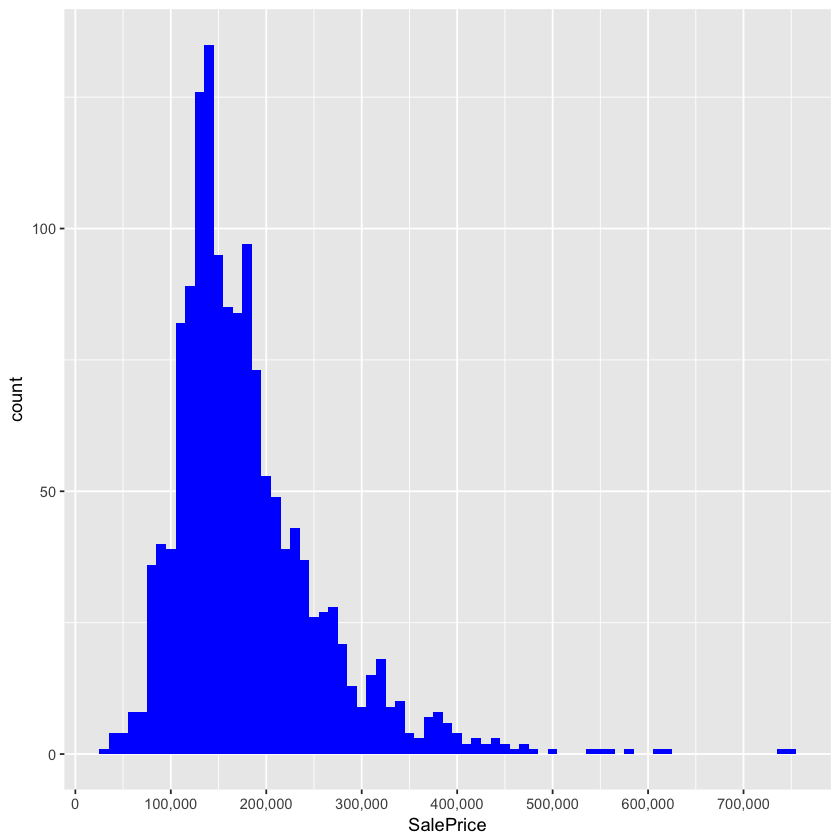

In [462]:
ggplot(data=data[!is.na(data$SalePrice),], aes(x=SalePrice)) + 
    geom_histogram(fill="blue", binwidth = 10000) +
    scale_x_continuous(breaks= seq(0, 800000, by=100000), labels = comma)

## Understanding Correlation with SalePrice variable

In [463]:
numVariables <- which(sapply(data, is.numeric)) #index vector numeric variables
numVariablesNames <- names(numVariables) #saving names vector for use later on

data_numericVar <- data[, numVariables]
corr_numericVar <- cor(data_numericVar, use="pairwise.complete.obs")
corr_sorted <- as.matrix(sort(corr_numericVar[,'SalePrice'], decreasing = TRUE)) #Descending sort on SalePrice
finalCorr <- names(which(apply(corr_sorted, 1, function(x) abs(x)>0.5))) #Filter highly correlated values
corr_numericVar <- corr_numericVar[finalCorr, finalCorr]

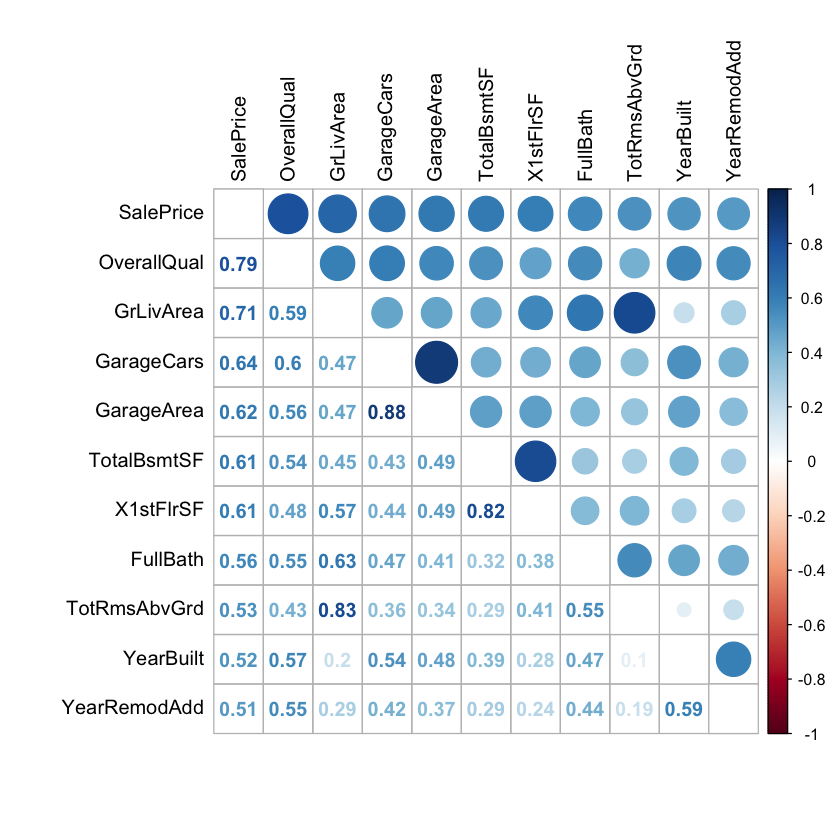

In [464]:
corrplot.mixed(corr_numericVar, tl.col="black", tl.pos = "lt")

## Overall Quality v/s Sales Price

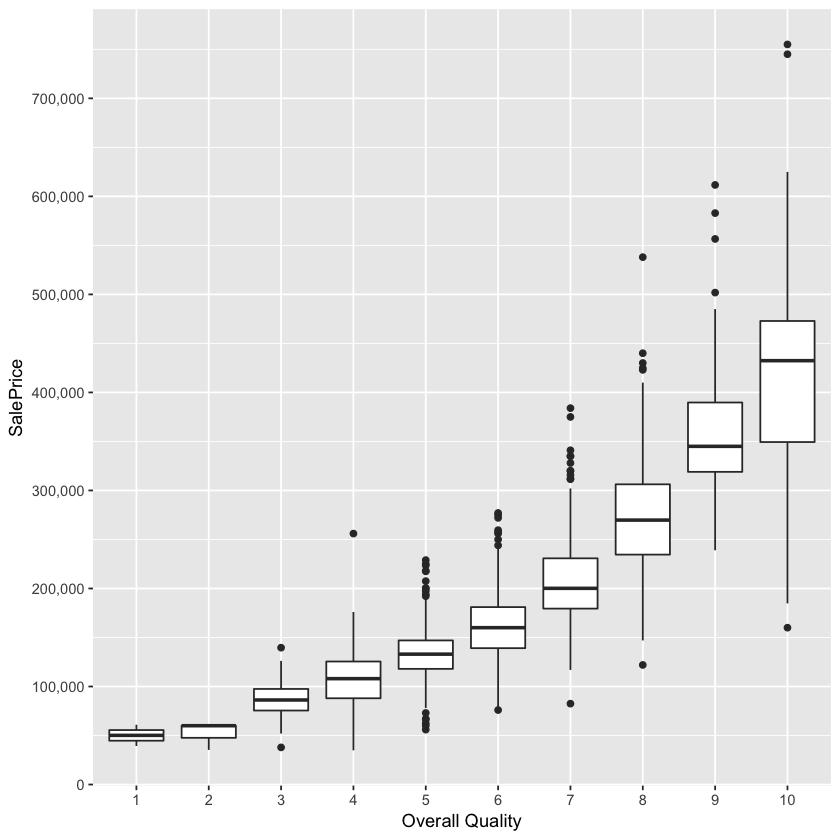

In [465]:
ggplot(data=data[!is.na(data$SalePrice),], aes(x=factor(OverallQual), y=SalePrice))+
        geom_boxplot() + labs(x='Overall Quality') +
        scale_y_continuous(breaks= seq(0, 800000, by=100000), labels = comma)

## Above Ground Living Area v/s Sales Price

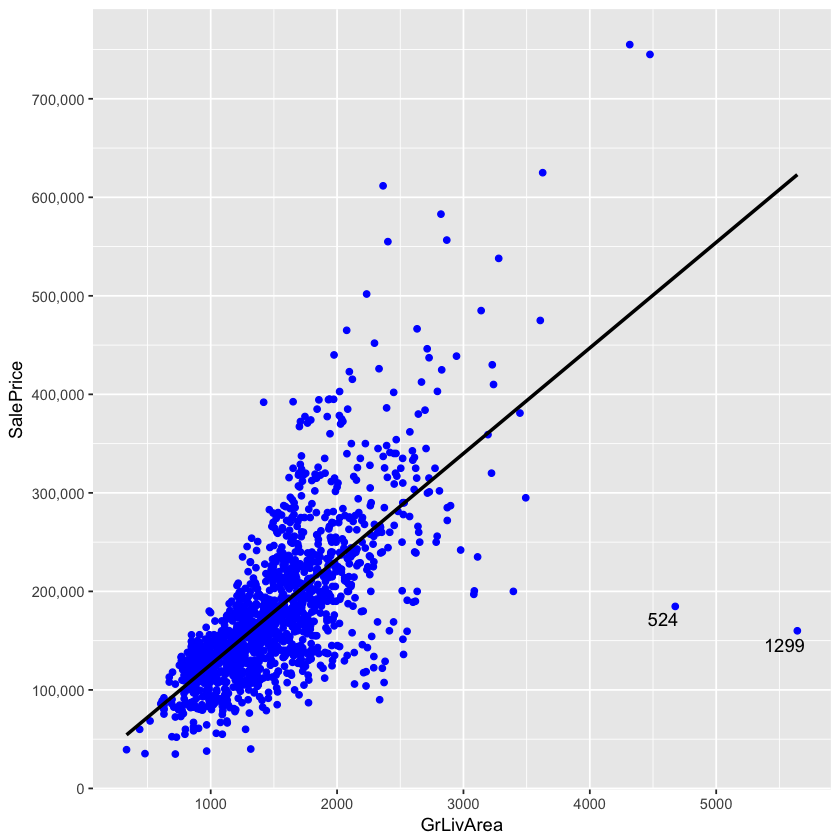

In [466]:
ggplot(data=data[!is.na(data$SalePrice),], aes(x=GrLivArea, y=SalePrice))+
        geom_point(col='blue') + geom_smooth(method = "lm", se=FALSE, color="black", aes(group=1)) +
        scale_y_continuous(breaks= seq(0, 800000, by=100000), labels = comma) +
        geom_text_repel(aes(label = ifelse(data$GrLivArea[!is.na(data$SalePrice)]>4500, rownames(data), '')))

## Imputing missing variables in the dataset

In [467]:
data$PoolQC[is.na(data$PoolQC)] <- 'None'
Qualities <- c('None' = 0, 'Po' = 1, 'Fa' = 2, 'TA' = 3, 'Gd' = 4, 'Ex' = 5)
data$PoolQC <- as.integer(revalue(data$PoolQC, Qualities))

# Miscellaneous Features
data$MiscFeature[is.na(data$MiscFeature)] <- 'None'
data$MiscFeature <- as.factor(data$MiscFeature)

# Garage variables
data$GarageYrBlt[is.na(data$GarageYrBlt)] <- data$YearBuilt[is.na(data$GarageYrBlt)]
data$GarageType[is.na(data$GarageType)] <- 'No Garage'
data$GarageType <- as.factor(data$GarageType)
data$GarageQual[is.na(data$GarageQual)] <- 'None'
data$GarageQual<-as.integer(revalue(data$GarageQual, Qualities))
data$GarageCond[is.na(data$GarageCond)] <- 'None'
data$GarageCond<-as.integer(revalue(data$GarageCond, Qualities))

# Alley Variables
data$Alley[is.na(data$Alley)] <- 'None'
data$Alley <- as.factor(data$Alley)

# Fence Quality
data$Fence[is.na(data$Fence)] <- 'None'

# Fireplace Quality
data$FireplaceQu[is.na(data$FireplaceQu)] <- 'None'
data$FireplaceQu <- as.integer(revalue(data$FireplaceQu, Qualities))

# Lot variables
for (i in 1:nrow(data)){
        if(is.na(data$LotFrontage[i])){
               data$LotFrontage[i] <- as.integer(median(data$LotFrontage[data$Neighborhood==data$Neighborhood[i]], na.rm=TRUE)) 
        }
}

data$LotConfig <- as.factor(data$LotConfig)

# Kitchen, Table, Home Functionality, Exterior Utilities, Electrical Systems, and Scale Type variables
data$KitchenQual[is.na(data$KitchenQual)] <- 'TA' #replace with most common value
data$KitchenQual <- as.integer(revalue(data$KitchenQual, Qualities))
data$Utilities <- NULL
data$Functional[is.na(data$Functional)] <- names(sort(-table(data$Functional)))[1]
data$Functional <- as.integer(revalue(data$Functional, 
              c('Sal'=0, 'Sev'=1, 'Maj2'=2, 'Maj1'=3, 'Mod'=4, 'Min2'=5, 'Min1'=6, 'Typ'=7)))
data$Exterior1st[is.na(data$Exterior1st)] <- names(sort(-table(data$Exterior1st)))[1]
data$Exterior1st <- as.factor(data$Exterior1st)
data$Electrical[is.na(data$Electrical)] <- names(sort(-table(data$Electrical)))[1]

data$Electrical <- as.factor(data$Electrical)
data$SaleType[is.na(data$SaleType)] <- names(sort(-table(data$SaleType)))[1]
data$SaleType <- as.factor(data$SaleType)
data$SaleCondition <- as.factor(data$SaleCondition)

# Masonry & MS Zoning variables 
data$MasVnrType[is.na(data$MasVnrType)] <- 'None'
data$MasVnrArea[is.na(data$MasVnrArea)] <-0
data$MSZoning[is.na(data$MSZoning)] <- names(sort(-table(data$MSZoning)))[1]
data$MSZoning <- as.factor(data$MSZoning)

The following `from` values were not present in `x`: Po, TA
The following `from` values were not present in `x`: None, Po
The following `from` values were not present in `x`: Sal


In [468]:
head(data)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,None,Reg,Lvl,Inside,⋯,0,0,None,None,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,None,Reg,Lvl,FR2,⋯,0,0,None,None,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,None,IR1,Lvl,Inside,⋯,0,0,None,None,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,None,IR1,Lvl,Corner,⋯,0,0,None,None,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,None,IR1,Lvl,FR2,⋯,0,0,None,None,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,None,IR1,Lvl,Inside,⋯,0,0,MnPrv,Shed,700,10,2009,WD,Normal,143000


In [469]:
# Factorizing the character variables
data$RoofStyle <- as.factor(data$RoofStyle)
data$RoofMatl <- as.factor(data$RoofMatl)
data$Foundation <- as.factor(data$Foundation)
data$LandContour <- as.factor(data$LandContour)
data$LandSlope<-as.integer(revalue(data$LandSlope, c('Sev'=0, 'Mod'=1, 'Gtl'=2)))
data$BldgType <- as.factor(data$BldgType)
data$Street<-as.integer(revalue(data$Street, c('Grvl'=0, 'Pave'=1)))
data$PavedDrive<-as.integer(revalue(data$PavedDrive, c('N'=0, 'P'=1, 'Y'=2)))
data$Heating <- as.factor(data$Heating)
data$HeatingQC<-as.integer(revalue(data$HeatingQC, Qualities))
data$HouseStyle <- as.factor(data$HouseStyle)
data$Neighborhood <- as.factor(data$Neighborhood)
data$CentralAir<-as.integer(revalue(data$CentralAir, c('N'=0, 'Y'=1)))
data$Condition1 <- as.factor(data$Condition1)
data$Condition2 <- as.factor(data$Condition2)

The following `from` values were not present in `x`: None


In [470]:
data$MSSubClass <- as.factor(data$MSSubClass)
colIdentifiers <- c('20'='1 story 1946+', '30'='1 story 1945-', '40'='1 story unf attic', '45'='1,5 story unf', '50'='1,5 story fin', '60'='2 story 1946+', '70'='2 story 1945-', '75'='2,5 story all ages', '80'='split/multi level', '85'='split foyer', '90'='duplex all style/age', '120'='1 story PUD 1946+', '150'='1,5 story PUD all', '160'='2 story PUD 1946+', '180'='PUD multilevel', '190'='2 family conversion')
data$MSSubClass<-revalue(data$MSSubClass, colIdentifiers)
str(data$MSSubClass)

The following `from` values were not present in `x`: 150


 Factor w/ 15 levels "1 story 1946+",..: 6 1 6 7 6 5 1 6 5 15 ...


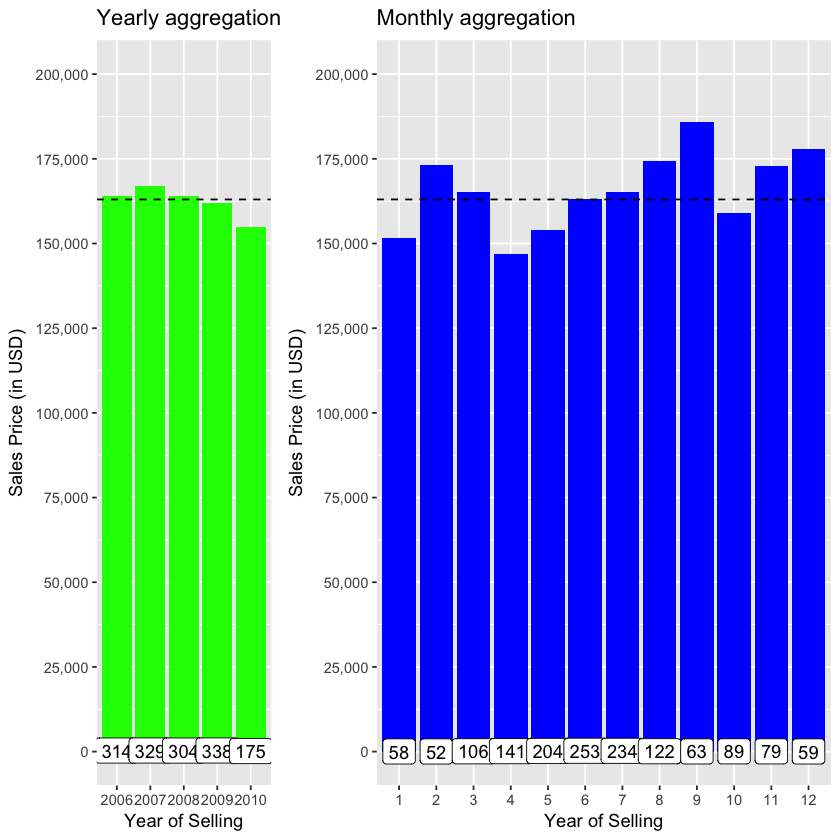

In [471]:
data$MoSold <- as.factor(data$MoSold)

soldOutYear <- ggplot(data[!is.na(data$SalePrice),], aes(x=as.factor(YrSold), y=SalePrice)) +
    geom_bar(stat='summary', fun.y = "median", fill='green')+
    scale_y_continuous(breaks= seq(0, 800000, by=25000), labels = comma) +
    geom_label(stat = "count", aes(label = ..count.., y = ..count..)) + coord_cartesian(ylim = c(0, 200000)) +
    geom_hline(yintercept=163000, linetype="dashed", color = "black") + 
    xlab('Year of Selling') + ylab('Sales Price (in USD)') + ggtitle('Yearly aggregation')

soldOutMonth <- ggplot(data[!is.na(data$SalePrice),], aes(x=MoSold, y=SalePrice)) +
    geom_bar(stat='summary', fun.y = "median", fill='blue')+
    scale_y_continuous(breaks= seq(0, 800000, by=25000), labels = comma) +
    geom_label(stat = "count", aes(label = ..count.., y = ..count..)) + coord_cartesian(ylim = c(0, 200000)) +
    geom_hline(yintercept=163000, linetype="dashed", color = "black") + 
    xlab('Year of Selling') + ylab('Sales Price (in USD)') + ggtitle('Monthly aggregation')

grid.arrange(soldOutYear, soldOutMonth, widths=c(1,2))

In [472]:
data=data %>% mutate_if(is.character, as.factor)

## Understanding changes in the correlation variables

In [473]:
new_var_numeric <- which(sapply(data, is.numeric))
new_var_factors <- which(sapply(data, is.factor))

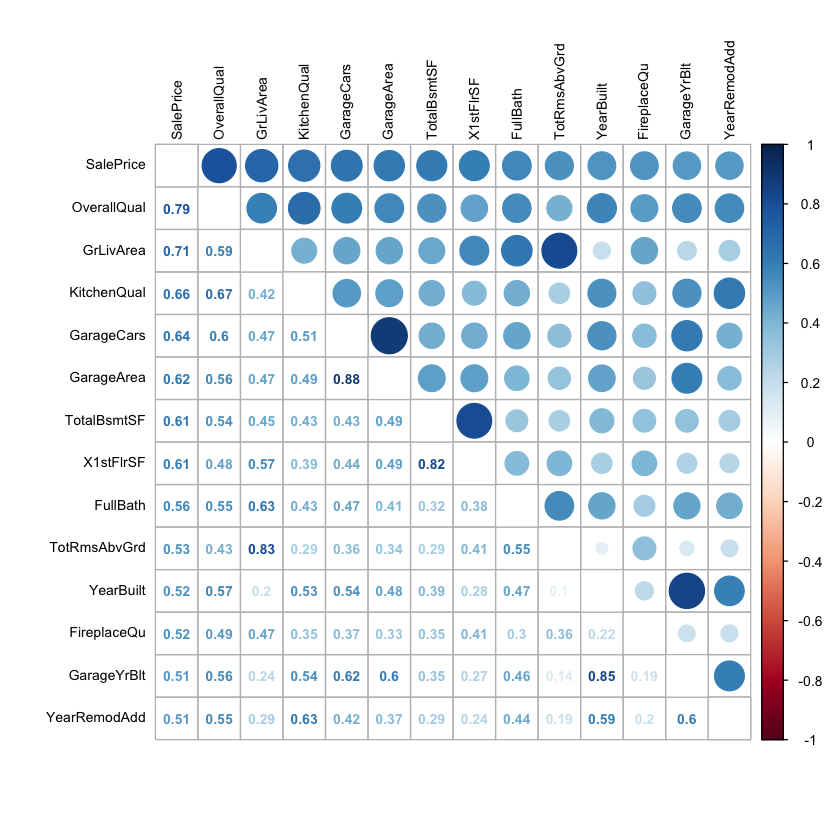

In [474]:
new_data_numVar <- data[, new_var_numeric]
new_corr <- cor(new_data_numVar, use="pairwise.complete.obs")
new_sorted_corr <- as.matrix(sort(new_corr[,'SalePrice'], decreasing = TRUE))
highly_corr_v <- names(which(apply(new_sorted_corr, 1, function(x) abs(x)>0.5)))
new_corr <- new_corr[highly_corr_v, highly_corr_v]

corrplot.mixed(new_corr, tl.col="black", tl.pos = "lt", tl.cex = 0.7,cl.cex = .7, number.cex=.7)

## Using Random Forest to understand the most contributing variables in the processed dataframe

In [475]:
new_data <- data
new_data$BsmtQual <- with(new_data, ave(SaleType, BsmtQual, FUN = function(x) replace(x, is.na(x), mean(x, na.rm = TRUE))))
new_data$BsmtCond <- with(new_data, ave(SaleType, BsmtCond, FUN = function(x) replace(x, is.na(x), mean(x, na.rm = TRUE))))
new_data$BsmtExposure <- with(new_data, ave(SaleType, BsmtExposure, FUN = function(x) replace(x, is.na(x), mean(x, na.rm = TRUE))))
new_data$BsmtFinType1 <- with(new_data, ave(SaleType, BsmtFinType1, FUN = function(x) replace(x, is.na(x), mean(x, na.rm = TRUE))))
new_data$BsmtFinType2 <- with(new_data, ave(SaleType, BsmtFinType2, FUN = function(x) replace(x, is.na(x), mean(x, na.rm = TRUE))))
new_data$GarageFinish <- with(new_data, ave(SaleType, GarageFinish, FUN = function(x) replace(x, is.na(x), mean(x, na.rm = TRUE))))

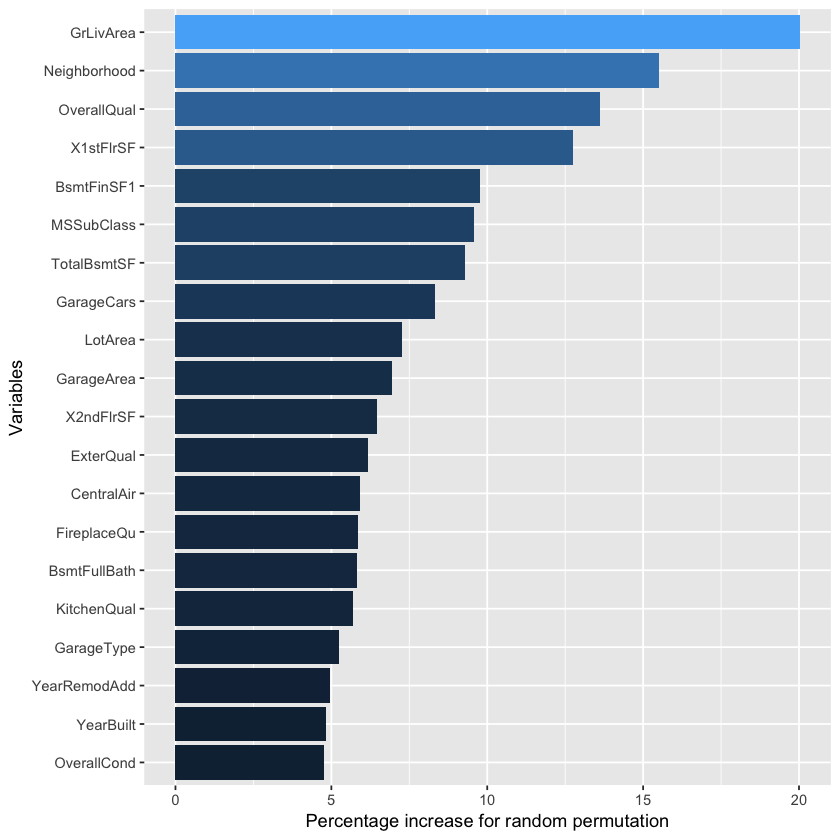

In [476]:
set.seed(1900)
mapping_data <- new_data
mapping_data$SalePrice <- NULL
data_random_forest <- randomForest(x=mapping_data[1:1460, -79], y=new_data$SalePrice[1:1460], ntree=150, importance=TRUE)
computed_random_forest <- importance(data_random_forest)
computed_random_forest_df <- data.frame(Variables = row.names(computed_random_forest), MSE = computed_random_forest[,1])
computed_random_forest_df <- computed_random_forest_df[order(computed_random_forest_df$MSE, decreasing = TRUE),]

ggplot(computed_random_forest_df[1:20,], aes(x=reorder(Variables, MSE), y=MSE, fill=MSE)) + 
    geom_bar(stat = 'identity') + labs(x = 'Variables', y= 'Percentage increase for random permutation') + 
    coord_flip() + theme(legend.position="none")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


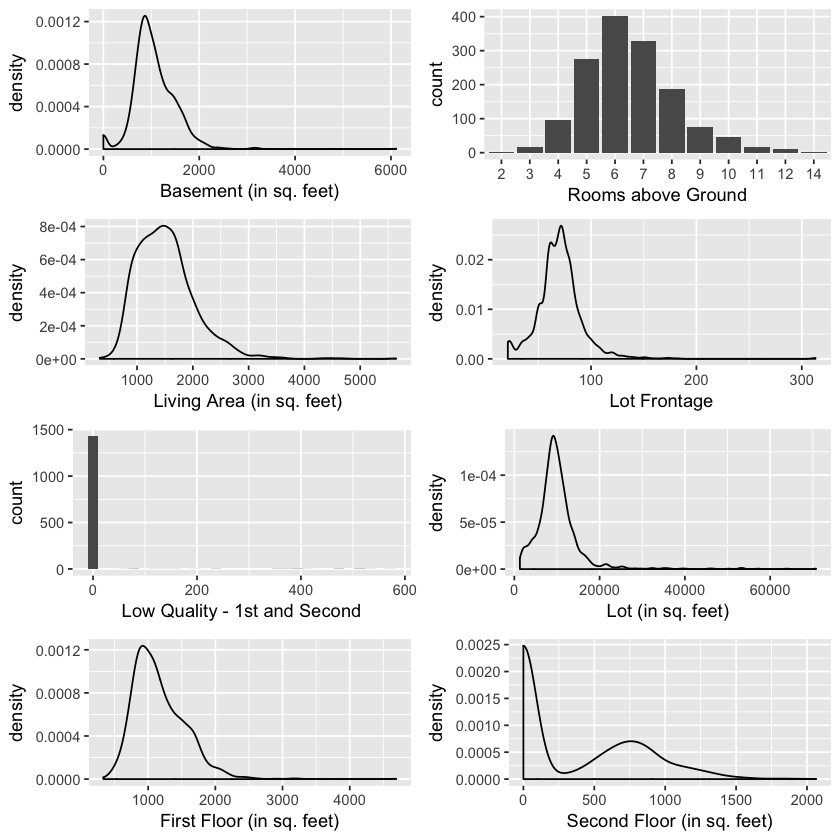

In [477]:
plot_1 <- ggplot(data= new_data, aes(x=TotalBsmtSF)) + geom_density() + labs(x='Basement (in sq. feet)')
plot_2 <- ggplot(data=new_data, aes(x=as.factor(TotRmsAbvGrd))) + geom_histogram(stat='count') + labs(x='Rooms above Ground')
plot_3 <- ggplot(data= new_data, aes(x=LotFrontage)) + geom_density() + labs(x='Lot Frontage')
plot_4 <- ggplot(data= new_data, aes(x=LowQualFinSF)) + geom_histogram() + labs(x='Low Quality - 1st and Second')
plot_5 <- ggplot(data= new_data, aes(x=GrLivArea)) + geom_density() + labs(x='Living Area (in sq. feet)')
plot_6 <- ggplot(data= new_data, aes(x=X1stFlrSF)) + geom_density() + labs(x='First Floor (in sq. feet)')
plot_7 <- ggplot(data= new_data, aes(x=X2ndFlrSF)) + geom_density() + labs(x='Second Floor (in sq. feet)')
plot_8 <- ggplot(data= new_data[new_data$LotArea<100000,], aes(x=LotArea)) + geom_density() + labs(x='Lot (in sq. feet)')

multiplot(plot_1, plot_2, plot_3, plot_4, plot_5, plot_6, plot_7, plot_8, layout = matrix(c(1,2,5,3,4,8,6,7),4,2,byrow=TRUE))

In [478]:
#Skewness in the SalePrice column of the ingested data 
cat ("Skewness in the Sale Price = ", skew(new_data$SalePrice))

Skewness in the Sale Price =  1.879009

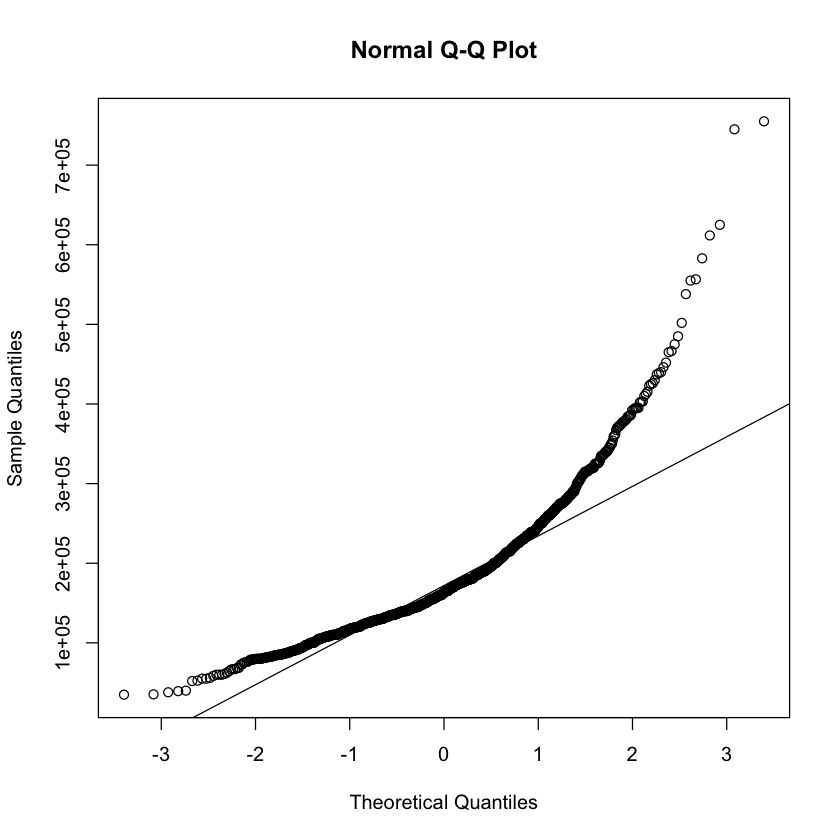

In [479]:
# Visualising the skewness of the SalePrice column
qqnorm(new_data$SalePrice)
qqline(new_data$SalePrice)

Skewness in the Sale Price =  0.1210859

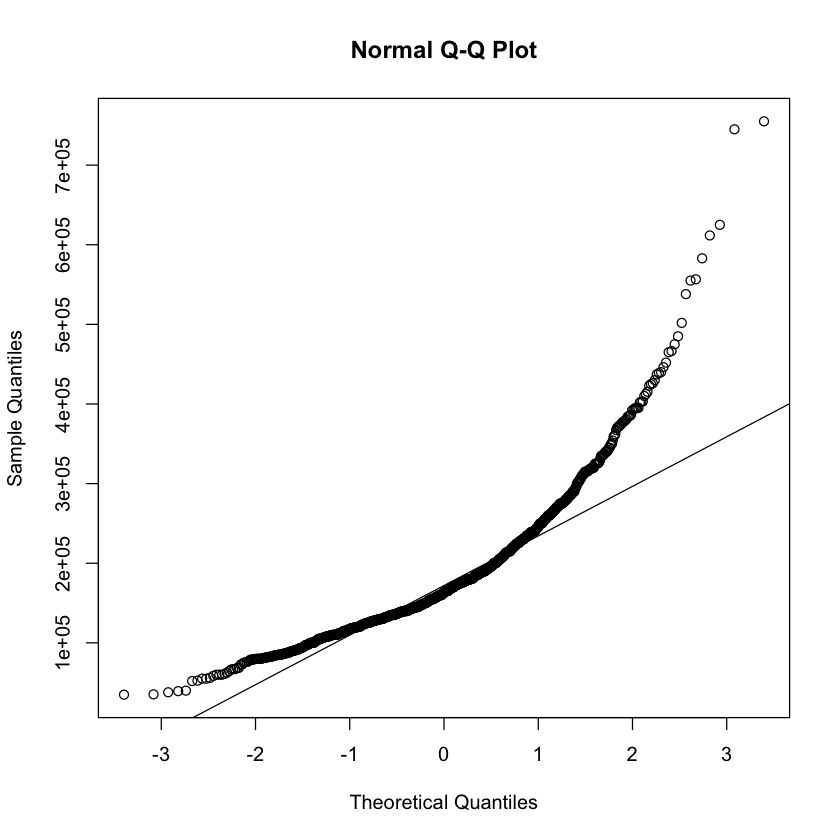

In [480]:
# For fixing the high right skewness and abnormal distribution, I will replace the SalePrice with the respective 
# logarithmic value
data$SalePrice <- log(new_data$SalePrice)
cat ("Skewness in the Sale Price = ", skew(data$SalePrice))

# Visualising the new skewness of the SalePrice column
qqnorm(new_data$SalePrice)
qqline(new_data$SalePrice)

## Pre-Modelling dataframe refinement

In [481]:
variablesToBeDropped <- c('GarageYrBlt', 'GarageCond', 'GarageArea', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'TotalRmsAbvGrd')
new_data_dropped <- new_data[, !(names(new_data) %in% variablesToBeDropped)]
data_numericVar <- data_numericVar[!(data_numericVar %in% 
c('Age', 'TotalSqFeet', 'TotBathrooms', 'TotalPorchSF', 'YrSold', 'MoSold', 'SalePrice', 'MSSubClass', 'OverallCond', 'OverallQual'))
                                  ]
new_data_numeric <- new_data_dropped[, !(names(new_data_dropped) %in% data_numericVar)]
new_data_factors <- new_data_dropped[, !(names(new_data_dropped) %in% data_numericVar)]
new_data_factors <- new_data_factors[, names(new_data_factors) != 'SalePrice']

In [482]:
for(i in 1:ncol(new_data_numeric))
  {
    if (!is.na(as.numeric(abs(skew(new_data_numeric[,i])))) && as.numeric(abs(skew(new_data_numeric[,i]))) > 0.8)
      {
        new_data_numeric[,i] <- log(new_data_numeric[,i] +1)
      }
  }

In [484]:
normalized_data_numeric <- preProcess(new_data_numeric, method = c("center", "scale"))
normalized_data_numeric_df <- predict(normalized_data_numeric, new_data_numeric)
encoded_new_data_factors <- as.data.frame(model.matrix(~.-1, new_data_factors))
combined <- cbind(normalized_data_numeric_df, encoded_new_data_factors)

In [485]:
new_data[sapply(new_data, is.integer)] <- lapply(new_data[sapply(new_data, is.integer)], as.factor)
new_data[sapply(new_data, is.numeric)] <- lapply(new_data[sapply(new_data, is.numeric)], as.factor)

In [486]:
model_train <- combined[!is.na(new_data$SalePrice),]
model_test <- combined[is.na(new_data$SalePrice),]

model_train_mat <- data.matrix(subset(model_train))
model_test_mat <- data.matrix(subset(model_test))

## Building Lasso Regression Model on the processed data

In [488]:
set.seed(1500)
ctrl_param <- trainControl(method="cv", number=5)
param_lasso_grid <- expand.grid(alpha = 1, lambda = seq(0.001,0.1,by = 0.0005))

lasso_mod <- train(x=model_train_mat, y=new_data$SalePrice[!is.na(new_data$SalePrice)], method='glmnet', 
                   trControl= ctrl_param, tuneGrid=param_lasso_grid)

In [ ]:
lasso_mod$bestTune
min(lasso_mod$results$RMSE)

In [ ]:
LassoPred <- predict(lasso_mod, test1)
predictions_lasso <- exp(LassoPred) #need to reverse the log to the real values
head(predictions_lasso)

In [489]:
new_data[sapply(new_data, is.integer)] <- lapply(new_data[sapply(new_data, is.integer)], as.factor)
new_data[sapply(new_data, is.numeric)] <- lapply(new_data[sapply(new_data, is.numeric)], as.factor)

In [490]:
model_train_columns <- names(model_train)
model_train_mat <- data.matrix(subset(model_train))
model_test_mat <- data.matrix(subset(model_test))

dtrain <- xgb.DMatrix(data = model_train_mat, label= label_train)
dtest <- xgb.DMatrix(data = model_train_mat)
default_param <-list(objective = "reg:linear", booster = "gbtree", eta=0.1, gamma=0, max_depth=6, min_child_weight=1, 
                     subsample=1, colsample_bytree=1, seed= 2018)


In [491]:
xgbcv <- xgb.cv( params = default_param, data = dtrain, nrounds = 500, nfold = 5, showsd = T, 
                stratified = T, print_every_n = 40, early_stopping_rounds = 10, maximize = F)
xgb_mod <- xgb.train(data = dtrain, params=default_param, nrounds = 120)

[1]	train-rmse:305.368366+2.371719	test-rmse:305.223950+9.452886 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 10 rounds.

[41]	train-rmse:4.950499+0.041144	test-rmse:5.023211+0.194610 
[81]	train-rmse:0.533859+0.010212	test-rmse:1.218017+0.077859 
Stopping. Best iteration:
[84]	train-rmse:0.511580+0.012152	test-rmse:1.214570+0.076180



In [492]:
predict_xgb <- predict(xgb_mod, dtest)
prediction_xgb <- exp(predict_xgb)
head(prediction_xgb)
cat ("\n")
tail (prediction_xgb)

[1] 1.159299e+179 3.795221e+147 3.048999e+192  4.723636e+84 1.651375e+215
[6]  3.855621e+88

[1] 6.620584e+152 5.583388e+136 5.223261e+180 1.677354e+229  6.559576e+86
[6]  3.197020e+96

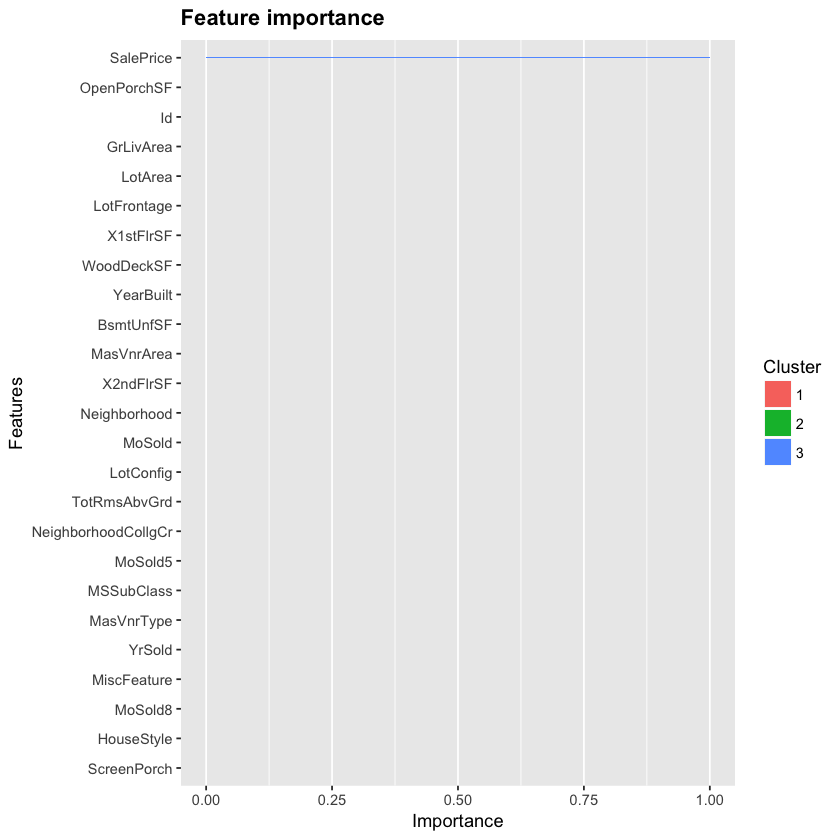

In [493]:
matrix_computer <- xgb.importance (feature_names = colnames(model_train_mat), model = xgb_mod)
xgb.ggplot.importance(importance_matrix = matrix_computer[1:25], rel_to_first = TRUE) 